In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/FDL21_RaVAEn_datasets/floods.zip" floods.zip
!unzip floods.zip
!rm floods.zip

Archive:  floods.zip
   creating: floods/
   creating: floods/EMSR333_02PORTOPALO/
   creating: floods/EMSR333_02PORTOPALO/changes_vector/
  inflating: floods/EMSR333_02PORTOPALO/changes_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/S2/
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-25.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-20.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-23.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-10-30.tif  
  inflating: floods/EMSR333_02PORTOPALO/S2/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/
  inflating: floods/EMSR333_02PORTOPALO/cloudprob_edited_vector/2018-11-04.geojson  
   creating: floods/EMSR333_02PORTOPALO/changes/
  inflating: floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif  
   creating: floods/EMSR333_02PORTOPALO/floodmap_edited/
  inflating: floods/EMSR333_02PORTOPALO/floodmap_edited/2018-11-04.geojson  
   creating: floods/EMSR271_02FARKADONA/
  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import os
import rasterio

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class FloodDataset(nn.Module):
    def __init__(self, patch_size=64):
        super(FloodDataset, self).__init__()
        self.patch_size = patch_size
        self.patches = []
        self.precompute_patches()

    def precompute_patches(self):
        root = os.listdir("floods")
        for path in root:
            img_paths = [os.path.join("floods", path, "S2", x) for x in os.listdir(os.path.join("floods", path, "S2")) if x.endswith(".tif")]
            for img_path in img_paths:
                with rasterio.open(img_path) as src:
                    img = src.read()  # Read all bands
                height, width = img.shape[1], img.shape[2]
                for row in range(0, height, self.patch_size):
                    for col in range(0, width, self.patch_size):
                        if row + self.patch_size <= height and col + self.patch_size <= width:
                            patch = img[:, row:row + self.patch_size, col:col + self.patch_size]
                            quantiles = np.quantile(patch, [0.01, 0.99], axis=(1, 2), keepdims=True)
                            patch = (patch - quantiles[0]) / (quantiles[1] - quantiles[0]+1e-5)
                            patch = np.clip(patch, 0,1)
                            patch = torch.tensor(patch, dtype=torch.float32)
                            if not torch.isnan(patch).any():
                                self.patches.append(patch)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]


In [3]:
ds = FloodDataset(patch_size=256)

split = 0.8
train_size = int(split * len(ds))
val_size = len(ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)



torch.Size([32, 15, 256, 256])


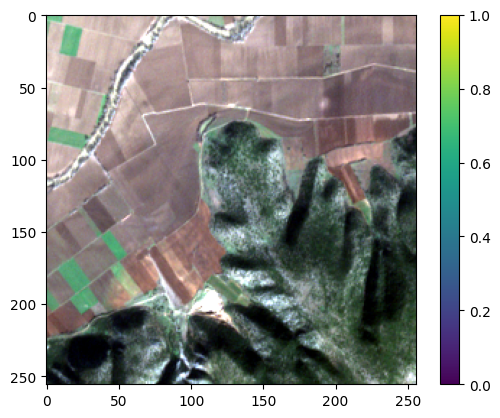

In [4]:
#Test train_loader
bands = [3,2,1]
data = next(iter(train_loader))
print(data.shape)
plt.imshow(data[0,bands,:,:].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        self.encoder = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=3, stride=2, padding=1),  # 4 input channels (
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32 input channels
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64 input channels
            nn.ReLU())
        self.fc_mu = nn.Linear(128 * 8 * 8 *16, self.latent_size)
        self.fc_logvar = nn.Linear(128 * 8 * 8 * 16, self.latent_size)
        self.fc_decode = nn.Linear(self.latent_size, 128 * 8 * 8*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # 128 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64 input channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 15, kernel_size=8, stride=2, padding=1),  # 32 input channels
            nn.Sigmoid())
        # 4 output channels (same as input)

    def encode(self, x):
        # Define the encoder part of the VAE
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        z = z.view(z.size(0), 128, 8*4, 8*4)
        x = self.decoder(z)
        return x

    def forward(self, x):
        # Forward pass through the VAE
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



In [6]:
def loss_function(recon_x, x, mu, logvar, gamma):
    # Define the loss function for the VAE
    # Gamma is the variance of the prior
    D = mu.size(1)
    MSE = D*(F.mse_loss(recon_x, x, reduction='sum')/(2*gamma.pow(2)) + (gamma.log()))
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)
    return MSE , KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, val_loader, gamma, optimizer, epochs):
    t_mse = []
    t_kld = []
    v_mse = []
    v_kld = []

    for epoch in range(epochs):
        model.train()
        train_loss_mse = 0
        train_loss_kld = 0
        train_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader)):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
            loss = mse + kld
            train_loss_kld += kld.item()
            train_loss_mse += mse.item()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        # Append train losses to lists after each epoch
        t_mse.append(train_loss_mse / len(train_loader.dataset))
        t_kld.append(train_loss_kld / len(train_loader.dataset))

        print(f"====> Epoch: {epoch} Average loss: {(train_loss) / len(train_loader.dataset):.4f}")

        val_loss_mse = 0
        val_loss_kld = 0
        val_loss = 0
        for batch_idx ,data in enumerate(val_loader):
            model.eval()
            data = data.to(device)
            with torch.no_grad():
                recon_batch, mu, logvar = model(data)
                mse, kld = loss_function(recon_batch, data, mu, logvar, gamma)
                v_loss = mse + kld
                val_loss_kld += kld.item()
                val_loss_mse += mse.item()
                val_loss += v_loss.item()
        # Append val losses to lists after each epoch
        v_mse.append(val_loss_mse / len(val_loader.dataset))
        v_kld.append(val_loss_kld / len(val_loader.dataset))

        print(f"====> Validation loss: {(val_loss) / len(val_loader.dataset):.4f}")

    return t_mse, t_kld, v_mse, v_kld

In [7]:
model = VAE(latent_size=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = torch.tensor([1]).to(device)
optimizer.add_param_group({'params': gamma})
train(model, train_loader, val_loader, gamma, optimizer, epochs=100)

16it [00:05,  2.78it/s]


====> Epoch: 0 Average loss: 15392480.3125
====> Validation loss: 12913390.2500


16it [00:05,  3.07it/s]


====> Epoch: 1 Average loss: 12889557.8125
====> Validation loss: 12494639.2500


16it [00:03,  4.07it/s]

====> Epoch: 2 Average loss: 12420306.0625


====> Validation loss: 11960236.0000


16it [00:03,  4.60it/s]

====> Epoch: 3 Average loss: 11826057.8750


====> Validation loss: 11612884.7500


16it [00:04,  3.51it/s]


====> Epoch: 4 Average loss: 11330467.0625
====> Validation loss: 11015196.2500


16it [00:03,  4.57it/s]

====> Epoch: 5 Average loss: 10690652.0000


====> Validation loss: 10439825.7500


16it [00:03,  4.47it/s]

====> Epoch: 6 Average loss: 9899297.0000


====> Validation loss: 9611293.2500


16it [00:04,  3.84it/s]

====> Epoch: 7 Average loss: 9109168.0625


====> Validation loss: 9100606.5000


16it [00:03,  4.46it/s]

====> Epoch: 8 Average loss: 8456341.5312


====> Validation loss: 8823588.5000


16it [00:03,  4.45it/s]

====> Epoch: 9 Average loss: 7924514.0938


====> Validation loss: 8273182.8750


16it [00:04,  3.71it/s]

====> Epoch: 10 Average loss: 7391930.0625


====> Validation loss: 7828518.5000


16it [00:03,  4.48it/s]

====> Epoch: 11 Average loss: 6939528.4688


====> Validation loss: 7483584.1250


16it [00:03,  4.16it/s]

====> Epoch: 12 Average loss: 6361863.0000


====> Validation loss: 7051429.8750


16it [00:04,  3.71it/s]

====> Epoch: 13 Average loss: 5763568.2188


====> Validation loss: 6515150.8750


16it [00:03,  4.51it/s]

====> Epoch: 14 Average loss: 5263208.5000


====> Validation loss: 6301722.7500


16it [00:04,  3.69it/s]

====> Epoch: 15 Average loss: 4919543.6875


====> Validation loss: 6047228.3750


16it [00:03,  4.32it/s]

====> Epoch: 16 Average loss: 4512570.4219


====> Validation loss: 5720025.0000


16it [00:03,  4.50it/s]

====> Epoch: 17 Average loss: 4207062.9844


====> Validation loss: 5570032.2500


16it [00:04,  3.98it/s]


====> Epoch: 18 Average loss: 4005232.8281
====> Validation loss: 5490489.8750


16it [00:03,  4.51it/s]

====> Epoch: 19 Average loss: 3818931.9531


====> Validation loss: 5244461.8750


16it [00:03,  4.45it/s]

====> Epoch: 20 Average loss: 3658159.7031


====> Validation loss: 5436140.2500


16it [00:04,  3.91it/s]

====> Epoch: 21 Average loss: 3630561.5469


====> Validation loss: 5295144.3750


16it [00:03,  4.53it/s]

====> Epoch: 22 Average loss: 3547394.2969


====> Validation loss: 5095901.5000


16it [00:03,  4.47it/s]

====> Epoch: 23 Average loss: 3316681.6719


====> Validation loss: 5023667.1250


16it [00:04,  3.77it/s]

====> Epoch: 24 Average loss: 3072136.2656


====> Validation loss: 4863431.7500


16it [00:03,  4.45it/s]

====> Epoch: 25 Average loss: 2877774.6719


====> Validation loss: 4704288.5000


16it [00:03,  4.46it/s]

====> Epoch: 26 Average loss: 2727042.6562


====> Validation loss: 4618339.1875


16it [00:04,  3.65it/s]

====> Epoch: 27 Average loss: 2611855.8125


====> Validation loss: 4658892.3125


16it [00:03,  4.43it/s]

====> Epoch: 28 Average loss: 2535631.2969


====> Validation loss: 4574478.7500


16it [00:03,  4.46it/s]

====> Epoch: 29 Average loss: 2470906.5625


====> Validation loss: 4542108.0000


16it [00:04,  3.97it/s]

====> Epoch: 30 Average loss: 2404522.5625


====> Validation loss: 4509776.8750


16it [00:03,  4.46it/s]

====> Epoch: 31 Average loss: 2362809.2812


====> Validation loss: 4559991.0000


16it [00:03,  4.29it/s]

====> Epoch: 32 Average loss: 2318466.9375


====> Validation loss: 4483579.5625


16it [00:03,  4.10it/s]

====> Epoch: 33 Average loss: 2298235.2188


====> Validation loss: 4483154.7500


16it [00:03,  4.49it/s]

====> Epoch: 34 Average loss: 2246233.4141


====> Validation loss: 4451384.8750


16it [00:03,  4.12it/s]


====> Epoch: 35 Average loss: 2171324.7812
====> Validation loss: 4481397.0625


16it [00:03,  4.56it/s]

====> Epoch: 36 Average loss: 2116191.0625


====> Validation loss: 4500554.5000


16it [00:03,  4.53it/s]

====> Epoch: 37 Average loss: 2058998.9609


====> Validation loss: 4408054.9375


16it [00:04,  3.84it/s]

====> Epoch: 38 Average loss: 2026072.0156


====> Validation loss: 4393869.5625


16it [00:03,  4.50it/s]

====> Epoch: 39 Average loss: 1959781.3984


====> Validation loss: 4433956.6875


16it [00:03,  4.54it/s]

====> Epoch: 40 Average loss: 1891732.2031


====> Validation loss: 4406613.1875


16it [00:04,  3.69it/s]

====> Epoch: 41 Average loss: 1833367.2344


====> Validation loss: 4360207.4375


16it [00:03,  4.52it/s]

====> Epoch: 42 Average loss: 1802341.3828


====> Validation loss: 4460984.3125


16it [00:03,  4.46it/s]

====> Epoch: 43 Average loss: 1823513.9453


====> Validation loss: 4425845.1875


16it [00:04,  3.74it/s]

====> Epoch: 44 Average loss: 1796857.4219


====> Validation loss: 4464959.9375


16it [00:03,  4.48it/s]

====> Epoch: 45 Average loss: 1763224.2969


====> Validation loss: 4402638.0625


16it [00:03,  4.45it/s]

====> Epoch: 46 Average loss: 1751737.7578


====> Validation loss: 4466826.1250


16it [00:04,  3.84it/s]

====> Epoch: 47 Average loss: 1812029.2266


====> Validation loss: 4409479.4375


16it [00:03,  4.46it/s]

====> Epoch: 48 Average loss: 1742516.5781


====> Validation loss: 4456848.3750


16it [00:03,  4.39it/s]

====> Epoch: 49 Average loss: 1697167.5156


====> Validation loss: 4431089.9375


16it [00:03,  4.11it/s]

====> Epoch: 50 Average loss: 1633587.7969


====> Validation loss: 4368031.5625


16it [00:03,  4.44it/s]

====> Epoch: 51 Average loss: 1562833.2109


====> Validation loss: 4355092.7500


16it [00:03,  4.12it/s]


====> Epoch: 52 Average loss: 1511274.8125
====> Validation loss: 4309331.1875


16it [00:03,  4.47it/s]

====> Epoch: 53 Average loss: 1473613.2188


====> Validation loss: 4355079.3125


16it [00:03,  4.46it/s]

====> Epoch: 54 Average loss: 1457227.2188


====> Validation loss: 4317038.1250


16it [00:04,  3.81it/s]

====> Epoch: 55 Average loss: 1432576.3828


====> Validation loss: 4309226.9375


16it [00:03,  4.53it/s]

====> Epoch: 56 Average loss: 1405820.5781


====> Validation loss: 4264529.6875


16it [00:03,  4.51it/s]

====> Epoch: 57 Average loss: 1391833.3516


====> Validation loss: 4295926.3125


16it [00:04,  3.82it/s]

====> Epoch: 58 Average loss: 1377370.7812


====> Validation loss: 4284885.4375


16it [00:03,  4.51it/s]

====> Epoch: 59 Average loss: 1355013.1406


====> Validation loss: 4295905.8750


16it [00:03,  4.52it/s]

====> Epoch: 60 Average loss: 1339391.8828


====> Validation loss: 4382171.9375


16it [00:04,  3.63it/s]

====> Epoch: 61 Average loss: 1323721.2578


====> Validation loss: 4335343.0000


16it [00:03,  4.53it/s]

====> Epoch: 62 Average loss: 1310643.2891


====> Validation loss: 4260456.3750


16it [00:03,  4.06it/s]

====> Epoch: 63 Average loss: 1286933.5391


====> Validation loss: 4241653.4375


16it [00:04,  3.80it/s]

====> Epoch: 64 Average loss: 1284128.6016


====> Validation loss: 4344666.6250


16it [00:04,  3.23it/s]


====> Epoch: 65 Average loss: 1288984.3828
====> Validation loss: 4297720.8125


16it [00:05,  2.89it/s]

====> Epoch: 66 Average loss: 1279333.3438


====> Validation loss: 4382437.3750


16it [00:03,  4.23it/s]

====> Epoch: 67 Average loss: 1289966.9766


====> Validation loss: 4262296.9375


16it [00:03,  4.32it/s]


====> Epoch: 68 Average loss: 1280004.1562
====> Validation loss: 4279072.9375


16it [00:04,  4.00it/s]


====> Epoch: 69 Average loss: 1261511.0234
====> Validation loss: 4353026.1250


16it [00:03,  4.26it/s]

====> Epoch: 70 Average loss: 1258502.0938


====> Validation loss: 4442320.3750


16it [00:05,  3.20it/s]

====> Epoch: 71 Average loss: 1266509.5156


====> Validation loss: 4341032.0625


16it [00:03,  4.36it/s]


====> Epoch: 72 Average loss: 1232168.0391
====> Validation loss: 4301725.2500


16it [00:03,  4.52it/s]

====> Epoch: 73 Average loss: 1208922.6562


====> Validation loss: 4291880.3125


16it [00:04,  3.70it/s]

====> Epoch: 74 Average loss: 1187169.3203


====> Validation loss: 4431078.2500


16it [00:03,  4.47it/s]

====> Epoch: 75 Average loss: 1183751.7891


====> Validation loss: 4315233.3750


16it [00:03,  4.51it/s]

====> Epoch: 76 Average loss: 1232776.3125


====> Validation loss: 4290829.1875


16it [00:04,  3.80it/s]

====> Epoch: 77 Average loss: 1239060.6172


====> Validation loss: 4473934.1250


16it [00:03,  4.48it/s]

====> Epoch: 78 Average loss: 1278635.9688


====> Validation loss: 4351348.6875


16it [00:03,  4.30it/s]

====> Epoch: 79 Average loss: 1236011.4844


====> Validation loss: 4329214.3125


16it [00:03,  4.22it/s]

====> Epoch: 80 Average loss: 1183385.7812


====> Validation loss: 4305056.1250


16it [00:03,  4.47it/s]

====> Epoch: 81 Average loss: 1138122.5898


====> Validation loss: 4384691.1250


16it [00:03,  4.04it/s]

====> Epoch: 82 Average loss: 1114270.2578


====> Validation loss: 4264480.5000


16it [00:03,  4.49it/s]

====> Epoch: 83 Average loss: 1088134.5664


====> Validation loss: 4287290.4375


16it [00:03,  4.52it/s]

====> Epoch: 84 Average loss: 1060840.9727


====> Validation loss: 4285807.1250


16it [00:04,  3.86it/s]

====> Epoch: 85 Average loss: 1049716.3477


====> Validation loss: 4248137.3750


16it [00:03,  4.52it/s]

====> Epoch: 86 Average loss: 1041308.1680


====> Validation loss: 4268819.8750


16it [00:03,  4.53it/s]

====> Epoch: 87 Average loss: 1030292.8984


====> Validation loss: 4240461.1875


16it [00:04,  3.88it/s]

====> Epoch: 88 Average loss: 1025416.5664


====> Validation loss: 4257172.1875


16it [00:03,  4.51it/s]

====> Epoch: 89 Average loss: 1022105.9531


====> Validation loss: 4270629.9375


16it [00:03,  4.53it/s]

====> Epoch: 90 Average loss: 1027671.1328


====> Validation loss: 4352917.0625


16it [00:04,  3.75it/s]

====> Epoch: 91 Average loss: 1088786.6055


====> Validation loss: 4284314.8125


16it [00:03,  4.48it/s]

====> Epoch: 92 Average loss: 1141963.2266


====> Validation loss: 4282475.3750


16it [00:03,  4.47it/s]

====> Epoch: 93 Average loss: 1128484.8555


====> Validation loss: 4263493.6875


16it [00:04,  3.63it/s]

====> Epoch: 94 Average loss: 1123818.3828


====> Validation loss: 4268005.5625


16it [00:03,  4.45it/s]

====> Epoch: 95 Average loss: 1116975.0859


====> Validation loss: 4303570.0000


16it [00:03,  4.38it/s]


====> Epoch: 96 Average loss: 1081607.7578
====> Validation loss: 4327756.5625


16it [00:04,  3.92it/s]

====> Epoch: 97 Average loss: 1044743.3125


====> Validation loss: 4261463.4375


16it [00:03,  4.50it/s]

====> Epoch: 98 Average loss: 1010291.7344


====> Validation loss: 4201533.2500


16it [00:03,  4.26it/s]

====> Epoch: 99 Average loss: 985077.3008


====> Validation loss: 4279481.7500


([15386963.375,
  12886891.875,
  12419421.8125,
  11825216.3125,
  11329537.1875,
  10689616.25,
  9898311.75,
  9108079.0625,
  8455115.03125,
  7923140.3125,
  7390393.65625,
  6937845.53125,
  6360007.4375,
  5761452.46875,
  5260915.28125,
  4917208.1875,
  4510143.21875,
  4204417.375,
  4002495.9375,
  3816212.890625,
  3655399.140625,
  3627704.515625,
  3544814.71875,
  3314210.796875,
  3069607.234375,
  2875186.296875,
  2724380.375,
  2609084.578125,
  2532780.921875,
  2468007.96875,
  2401616.703125,
  2359905.515625,
  2315566.71875,
  2295361.1640625,
  2243405.2265625,
  2168458.4296875,
  2113280.1796875,
  2056052.390625,
  2023135.8359375,
  1956816.0390625,
  1888736.1015625,
  1830332.0390625,
  1799288.1171875,
  1820470.1796875,
  1793863.9609375,
  1760219.4375,
  1748678.0859375,
  1808901.6640625,
  1739559.6953125,
  1694298.0078125,
  1630739.2578125,
  1559936.2890625,
  1508312.5859375,
  1470626.296875,
  1454212.171875,
  1429555.5078125,
  1402782.0234

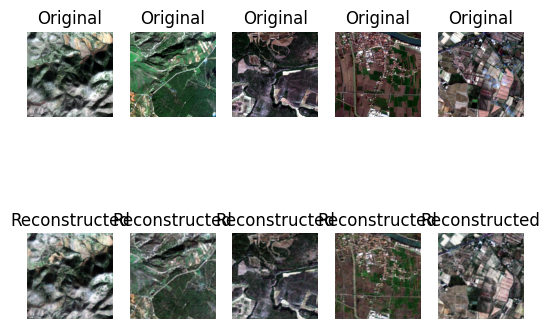

In [8]:
data = next(iter(val_loader))

data = data.to(device)
recon_batch, mu, logvar = model(data)
recon_batch = recon_batch.cpu().detach().numpy()
data = data.cpu().detach().numpy()

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(recon_batch[i, bands, :, :].transpose(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()



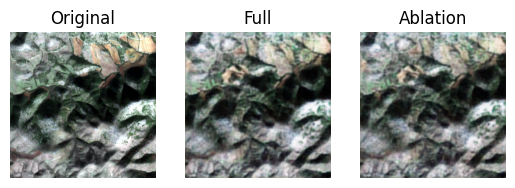

In [11]:
torch.cuda.empty_cache()
mu, logvar = model.encode(torch.Tensor(data[0:1]).to(device))
import numpy as np
mu, logvar = mu.cpu().detach().numpy(), logvar.cpu().detach().numpy()
# Generate batch without ablation
z_no_ablation = np.random.normal(loc=mu, scale=np.exp(logvar), size=(500,512))

recon_no_ablation = model.decode(torch.Tensor(z_no_ablation).to(device))
recon_no_ablation = recon_no_ablation.cpu().detach().numpy()

# Generate batch with ablation
z_ablation = torch.Tensor(z_no_ablation).clone()
z_ablation[:, 64:127] = 0
z_ablation = z_ablation.to(device)
recon_ablation = model.decode(z_ablation)
recon_ablation = recon_ablation.cpu().detach().numpy()

plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Full")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Ablation")
plt.axis('off')

plt.show()


err_map = np.var(data[0:1] - recon_no_ablation, axis=0)
err_map = np.mean(err_map, axis=0)

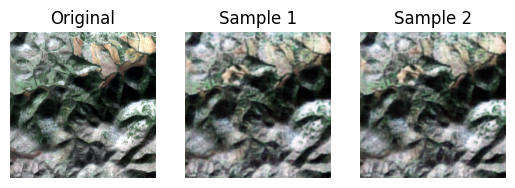

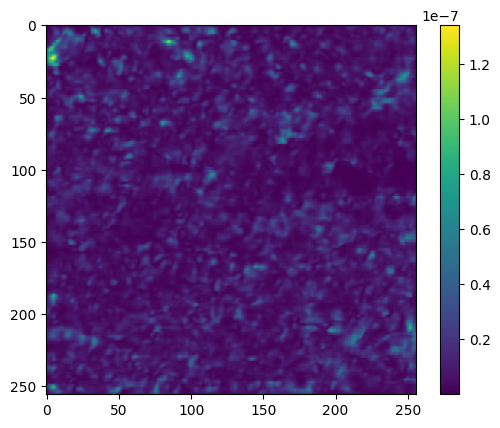

In [12]:
plt.subplot(1,3,1)
plt.imshow(data[0,bands,:,:].transpose(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(recon_no_ablation[0,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 1")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(recon_no_ablation[1,bands,:,:].transpose(1, 2, 0))
plt.title("Sample 2")
plt.axis('off')

plt.show()

plt.imshow(err_map)
plt.colorbar()
plt.show()

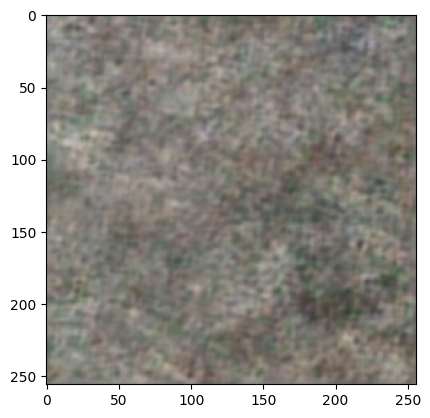

In [28]:
z_sample = torch.Tensor(np.random.randn(1,512)).to(device)
decod = model.decode(z_sample)

plt.imshow(decod[0,bands,:,:].cpu().detach().numpy().transpose(1, 2, 0))
plt.show()